# 1. Imports and First Look

In [16]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

import logging
import re
import nltk

from pathlib import Path
from collections import Counter
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

df_path = Path("../data/spam.csv")
df = pd.read_csv(df_path, encoding="latin-1")
df.info()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   v1          5572 non-null   str  
 1   v2          5572 non-null   str  
 2   Unnamed: 2  50 non-null     str  
 3   Unnamed: 3  12 non-null     str  
 4   Unnamed: 4  6 non-null      str  
dtypes: str(5)
memory usage: 217.8 KB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brennohdev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brennohdev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/brennohdev/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


As we see, Unnamed 2, 3, 4 are useless columns: We won't need it

# 2. Pre processing steps

In [17]:
class DataIngestor:
    """
    A class to handle data ingestion and preprocessing for NLP tasks.
    """
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None
        
    def load(self, encoding="latin-1"):
        try:
            self.df = pd.read_csv(self.file_path, encoding=encoding)
            return self
        except Exception as e:
            logging.error(f"Error loading data: {e}")
            raise e
        
    def drop_unused(self, columns: list):
        if self.df is not None:
            self.df = self.df.drop(columns=columns)
        return self
    
    def rename_for_nlp(self, mapping: dict):
        if self.df is not None:
            self.df = self.df.rename(columns=mapping)
        return self
    
    def get_data(self):
        return self.df

In [18]:
class FeatureExtractor:
    def __init__(self, text_column: str):
        self.text_column = text_column
        
    def extract(self, df):
        df_ext = df.copy()
        df_ext['exclamation_count'] = df_ext[self.text_column].str.count(r'!')
        df_ext['has_url'] = df_ext[self.text_column].str.contains(r'https?://\S+|www\.\S+').astype(int)
        df_ext['msg_length'] = df_ext[self.text_column].apply(len)
        return df_ext

In [19]:
class TextPreProcessor:
    def __init__(self, text_column: str, extra_stop_words: list = None):
        self.text_column = text_column
        self.df = None
        self.stop_words = set(stopwords.words('english'))
        if extra_stop_words:
            self.stop_words.update(extra_stop_words)
        
        self.lemmatizer = WordNetLemmatizer()
        
    def _lemmatize(self, tokens):
        return [self.lemmatizer.lemmatize(word) for word in tokens]

    def process(self, df):
        self.df = df.copy()
        new_col = f"processed_{self.text_column}"
        self.df[new_col] = (self.df[self.text_column]
                            .apply(self._normalize)
                            .apply(self._tokenize)
                            .apply(self._remove_stopwords)
                            .apply(self._lemmatize))
        
        return self.df

    def _normalize(self, text):
        text = text.lower()
        return re.sub(r'[^\w\s]', '', text)

    def _tokenize(self, text):
        return text.split()

    def _remove_stopwords(self, tokens):
        return [word for word in tokens if word not in self.stop_words]

In [22]:
loader = DataIngestor(df_path)
raw_df = (loader.load()
                  .drop_unused(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
                  .rename_for_nlp(mapping={'v1': 'label', 'v2': 'text'})
                  .get_data())

extractor = FeatureExtractor(text_column='text')
df_with_features = extractor.extract(raw_df)

noise = ['u', 'ur', '2', '4', 'ltgt', 'im', 'get', 'ok', 'ok', 'dont', 'ill']
preprocessor = TextPreProcessor(text_column='text', extra_stop_words=noise)
processed_df = preprocessor.process(df_with_features)

processed_df

,label,text,exclamation_count,has_url,msg_length,processed_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,0,111,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,0,29,"[lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,0,155,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,0,49,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0,61,"[nah, think, go, usf, life, around, though]"
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,0,161,"[2nd, time, tried, contact, å750, pound, prize..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,0,37,"[ì_, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",0,0,57,"[pity, mood, soany, suggestion]"
5570,ham,The guy did some bitching but I acted like i'd...,0,0,125,"[guy, bitching, acted, like, id, interested, b..."


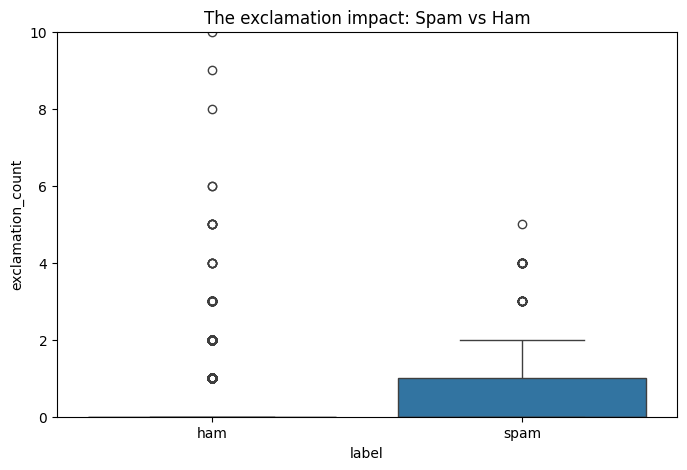

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='exclamation_count', data=processed_df)
plt.title("The exclamation impact: Spam vs Ham")
plt.ylim(0, 10)
plt.show()

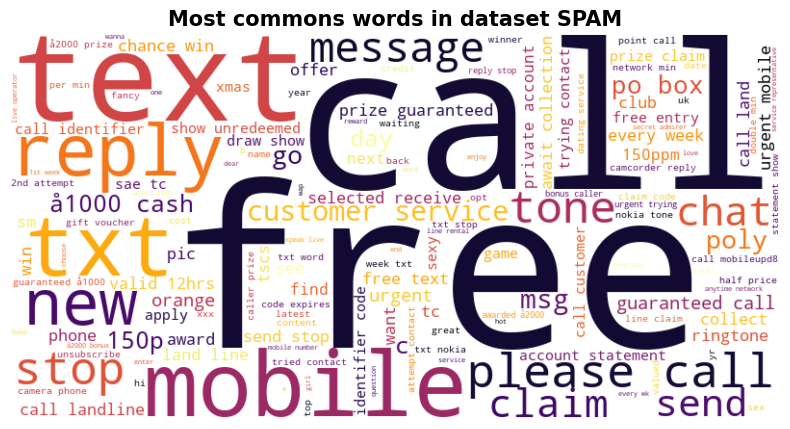

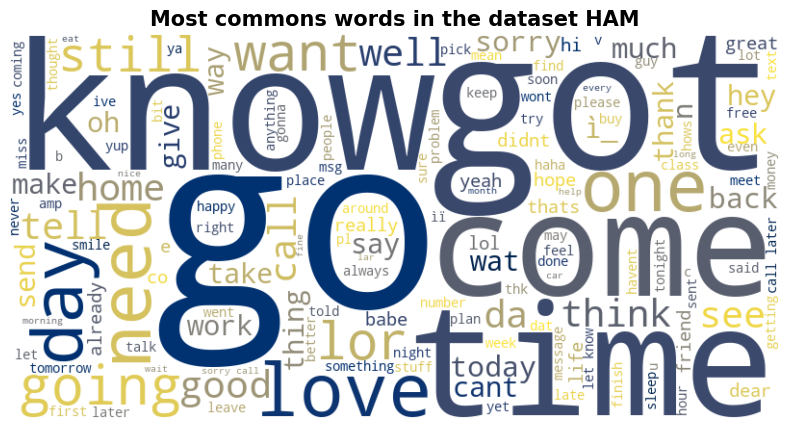

In [24]:
spam_text = " ".join([" ".join(tokens) for tokens in processed_df[processed_df['label'] == 'spam']['processed_text']])
ham_text = " ".join([" ".join(tokens) for tokens in processed_df[processed_df['label'] == 'ham']['processed_text']])

def plot_wordcloud(text, title, colormap='viridis'):
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap=colormap,
                   max_words=150, 
                   random_state=42 
                  ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.axis('off')
    plt.show()

plot_wordcloud(spam_text, "Most commons words in dataset SPAM", colormap='inferno')

plot_wordcloud(ham_text, "Most commons words in the dataset HAM", colormap='cividis')